Social Media and Network Analytics

Analysing and Tracking the Sentiment and Topics on Social Media Reddit and YouTube

"ANALYZING THE CHALLENGES ENCOUNTERED BY INTERNATIONAL STUDENTS VIA SOCIAL MEDIA ENGAGEMENT  (YouTube)"


Reddit(data collection)

In [2]:
%load_ext autoreload
%autoreload 1
%aimport redditClient

In [3]:
from redditClient import redditClient
import praw
import json
import sys
import string
from collections import Counter
import nltk
nltk.download('stopwords')
import matplotlib.pyplot as plt
import codecs
import re
import math
import pyLDAvis
import pyLDAvis.lda_model
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from colorama import Fore, Back, Style
import datetime
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
from colorama import Fore, Back, Style
import pandas as pd
from datetime import datetime
from country_list import countries_for_language

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/afrahhassan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/afrahhassan/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [4]:
%load_ext autoreload
%autoreload 1
%aimport RedditProcessing

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
# construct Reddit client
client = redditClient()

# sanity check, you should see your own username printed out
print(client.user.me())

Technical-Use9161


In [6]:
subreddit_name = ['internationalStudents']


In [7]:
# specify which subreddit we are interested in
for sub in subreddit_name:
    subreddit = client.subreddit(sub)

# print out the hot submisisons
    for submission in subreddit.hot(limit=None):
    # print title, but we can print other information as well
        print(submission.title)

About this subreddit
International Student struggles
what would be the best idea of stopping noises from upstairs
Time crunch and should I wait for my admission results to come out?
Studying at TUDelft
OPT extension requirements
Admission chances
Study abroad
Meeting the 4 years of ug requirement
I have a question
Need help with tax stuff
Credentials for college
Need advice on Masters. MHCI or MEM or?
High School Diploma Equivalent in Ontario
Are there any immigration lawyers who help students understand the nitty gritty of the laws?
Studying for GMAT
Is the UK a good choice for masters in Business related field?
MPH for international students
Did you expect the oppressed would hold hands and hug the murder out of their oppressors?
What are some of the niche online groups for international students?
Guess my Wes?
Advice for Medical leave and CPT
Am I eligible for application fee waiver?
International Student looking to stay in US. Please offer advice!
H1B visa status post MBA
Studying 

# Data Collection

In [8]:
start_date_str = '01-09-2022'
end_date_str = '30-09-2023'
start_date = datetime.strptime(start_date_str, '%d-%m-%Y').date()
end_date = datetime.strptime(end_date_str, '%d-%m-%Y').date()

with open("international_students.json", "a") as f:
    for post in subreddit.new(limit=None):        
        post_date = datetime.fromtimestamp(post.created).date()
        if start_date <= post_date <= end_date:
            sampledata = {
                'title': post.title,
                'author': post.author.name if post.author else None,
                'created': post_date.strftime('%Y-%m-%d'),
                'body': post.selftext,
                'num_comments': post.num_comments,
                'comments': []
            }
            post.comments.replace_more(limit=None)

            for comment in post.comments:                    
                comment_date = datetime.fromtimestamp(comment.created_utc).date()
                sampledata['comments'].append({
                    'author': comment.author.name if comment.author else None,
                    'created_utc': comment_date.strftime('%Y-%m-%d'),
                    'body': comment.body
                })

            json.dump(sampledata, f)
            f.write("\n")


In [9]:
with open("international_students.json", "r") as f:
    dSubmissions = [json.loads(line) for line in f]
    for sub in dSubmissions:
        title=sub.get('title','')
        print(title)
    

Considering enrolling as an international student in a BSN program in Australia
How to get friends as an international student with foreign language?
International student required savings help
How bad are my extracurriculars?
Looking for international students to interview
Warwick or Manchester
Where can I get my grades converted ?
Where to do my Masters in Business Analytics, Canada or Netherlands, if not where?
International student driving test.
Have any international transfers gotten a merit scholarship?
US citizen -India education - international student??
Opening a business on OPT
Graduate student question for international students!
Should I create a credit card ?
International Students with job offer beyond OPT Start Date
Which course should I go abroad for after bcom honours from Delhi university ?
Universities offer affordable on-campus master program in mental health counseling [international student]
International Beta Club
Biology major in USA and international students
C

# Data exploration

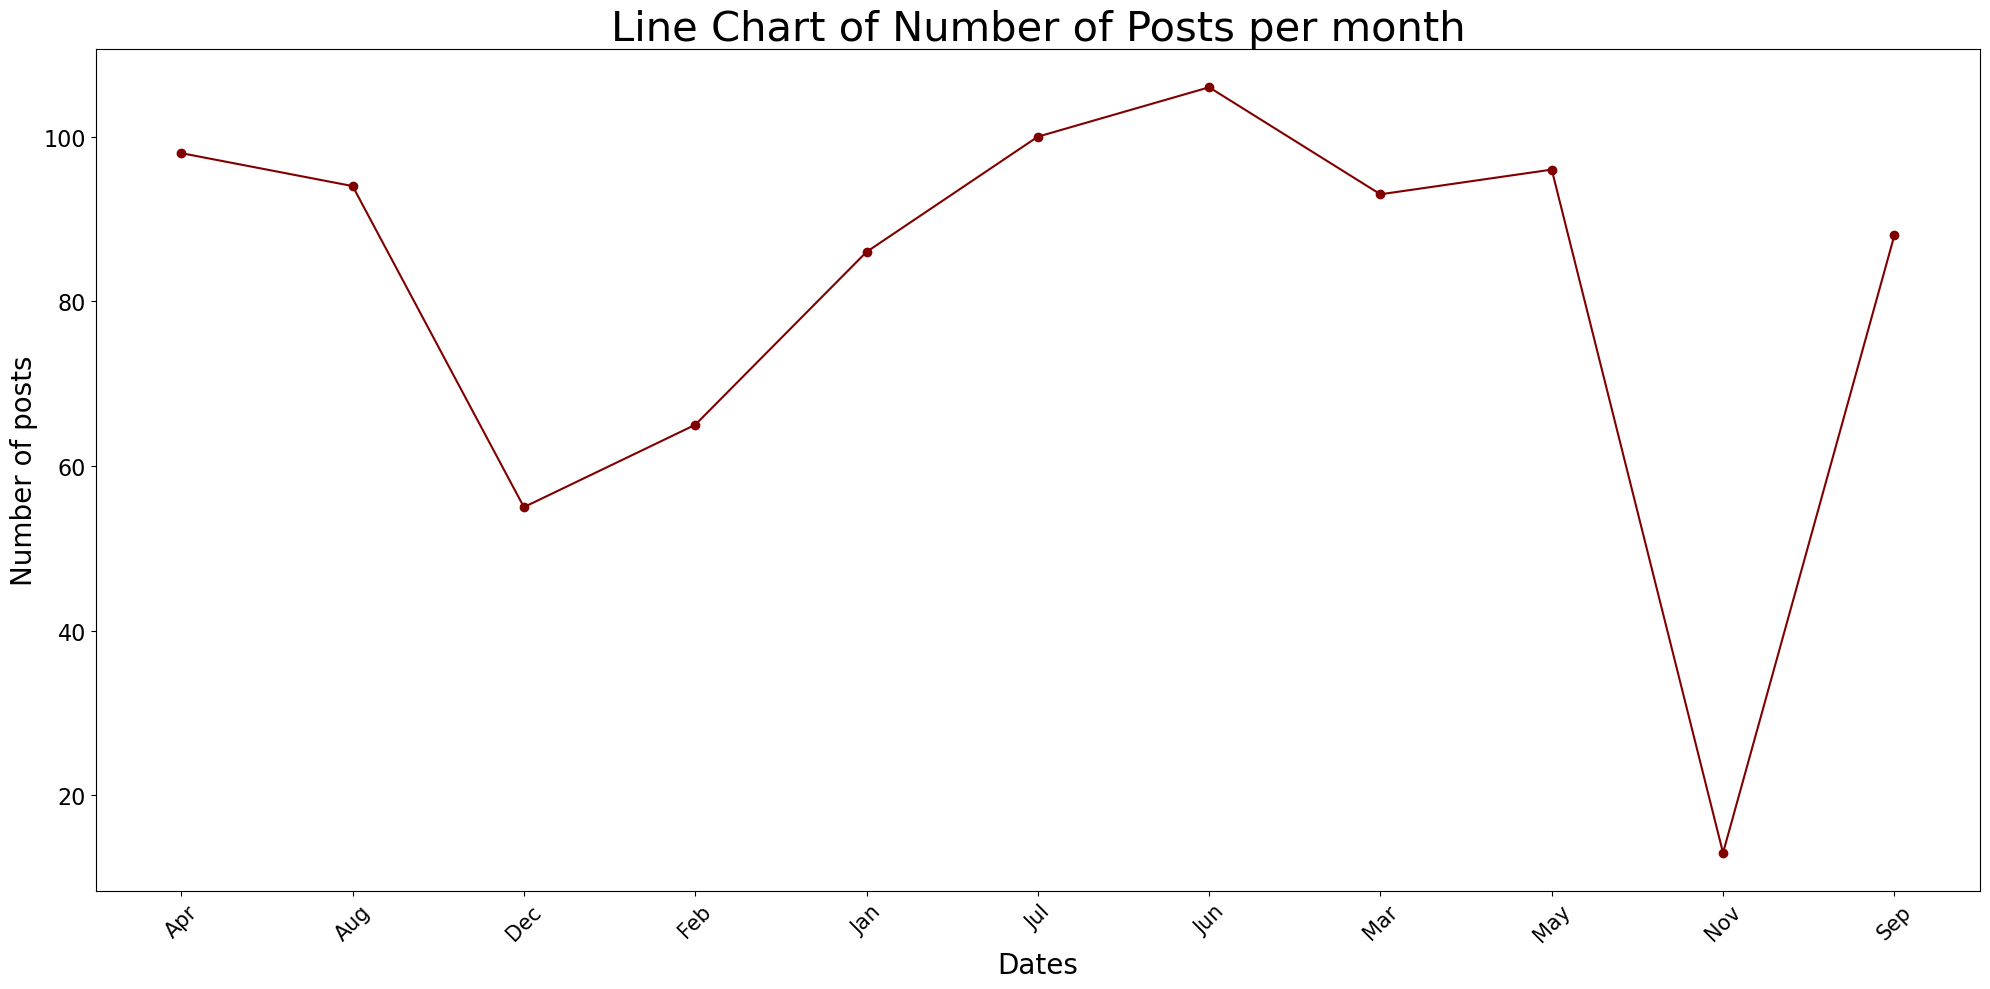

In [10]:

month_list={}
month_names={'01':'Jan','02':'Feb','03':'Mar','04':'Apr','05':'May','06':'Jun','07':'Jul','08':'Aug','09':'Sep','10':'Oct','11':'Nov','12':'Dec'}
month_data={}
with open("international_students.json", "r") as f:
    dSubmissions = [json.loads(line) for line in f]
    for submission in dSubmissions:
        created_dt = submission.get('created', ',')
        month=created_dt[5:-3]
        if month in month_list:
            month_list[month]+=1
        else:
            month_list[month]=1

for m in month_list.keys():
    if m in month_names:
        i=month_names[m]
        j=month_list[m]
        month_data[i]=j
        
x = list(month_data.keys())
y = list(month_data.values())


x, y = zip(*sorted(zip(x, y), key=lambda pair: pair[0]))

# Create a line chart
plt.figure(figsize=(20, 10))
plt.plot(x, y, color='maroon', marker='o', linestyle='-')  # Use 'o' as marker, '-' for solid line
plt.xlabel("Dates", fontsize=20)  # Increase font size here
plt.ylabel("Number of posts", fontsize=20)  # Increase font size here
plt.title("Line Chart of Number of Posts per month", fontsize=30)  # Increase font size here
plt.xticks(rotation=45, fontsize=15)  # Increase font size for x-axis tick labels
plt.yticks(fontsize=16)  # Increase font size for y-axis tick labels
plt.tight_layout()

# Show the line chart
plt.show()
            


In [11]:
## See how comments have increased in the past few posts. To understand the which topic has received more attention
data={}

with open("international_students.json", "r") as f:
    dSubmissions = [json.loads(line) for line in f]
    for submission in dSubmissions:     
        new=submission.get('title',',')
        #print(new)
        comments=submission.get('comments',',')
        num_of_comments= len(comments)
        if num_of_comments<5:
            pass
        else:
            data[new]=num_of_comments

   
x = list(data.keys())
y = list(data.values())
fig = plt.figure(figsize = (155, 155))
plt.barh(x, y, color ='blue')
plt.xticks(rotation=45)
plt.xticks(fontsize=150) 
plt.yticks(fontsize=150) 
plt.xlabel("Num_of_comments",fontsize=200)
plt.ylabel("Titles",fontsize=200)
plt.title("Posts/Questions that have received more attention",fontsize=300)
plt.show()            

C:\Users\Aishwarya C\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 128584 (\N{SEE-NO-EVIL MONKEY}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


In [5]:
import pandas as pd
import json
import nltk

word_counts = []

with open("international_students.json", "r") as file:
    for line in file:
        post_data = json.loads(line)
        comments = post_data.get("comments", [])

        total_words_in_comments = 0

        for comment in comments:
            comment_text = comment.get("body", "")
            words = nltk.word_tokenize(comment_text)
            total_words_in_comments += len(words)

    
        word_counts.append(total_words_in_comments)


total_word_count = sum(word_counts)

print(f"Total words in comments across all posts: {total_word_count}")

Total words in comments across all posts: 50441


# Data cleaning

In [6]:
def remove_emot(title):
    pattern = re.compile("["
        u"\U0001F600-\U0001F64F"
        u"\U0001F300-\U0001F5FF"
        u"\U0001F900-\U0001F9FF"
        u"\U0001FA70-\U0001FAFF"  
        u"\U0001F680-\U0001F6FF"
        "]+", re.UNICODE)
    return re.sub(pattern, '', title)

In [7]:
final_title=[]
cleaned_sub=[]
with open("intl_stud.json", "r") as f:
    dSubmissions = [json.loads(line) for line in f]
    for submission in dSubmissions:     
        title=submission.get('title','') 
        emo=remove_emot(title)
        val = re.sub('http://\S+|https://\S+', '', emo)
        final_title = val
        submission['title'] = final_title
        
        cleaned_sub.append(submission)

with open("intl_stud.json", "w") as t:
    for submission in cleaned_sub:
        json.dump(submission, t)
        t.write("\n")  

<>:8: DeprecationWarning: invalid escape sequence '\S'
<>:8: DeprecationWarning: invalid escape sequence '\S'
/var/folders/r2/1rg4bb0n4j9_gk6v2c2g48c40000gn/T/ipykernel_10239/2820220008.py:8: DeprecationWarning: invalid escape sequence '\S'
  val = re.sub('http://\S+|https://\S+', '', emo)
/var/folders/r2/1rg4bb0n4j9_gk6v2c2g48c40000gn/T/ipykernel_10239/2820220008.py:8: DeprecationWarning: invalid escape sequence '\S'
  val = re.sub('http://\S+|https://\S+', '', emo)


FileNotFoundError: [Errno 2] No such file or directory: 'intl_stud.json'

# Preprocessing

In [14]:
 def processText(text, tokenizer, stemmer, stopwords):
 
    # covert all to lower case
    text = text.lower()
    # tokenise
    lTokens = tokenizer.tokenize(text)
    # strip whitespaces before and after
    lTokens = [stemmer.stem(token.lower()) for token in lTokens if token.isalpha() and token.lower() not in stopwords]
    # stem (we use set to remove duplicates)
    lStemmedTokens = set([stemmer.stem(tok) for tok in lTokens])


    # remove stopwords, digits
    return [tok for tok in lStemmedTokens if tok not in stopwords and not tok.isdigit()]

## Identifying most common words and unique words afterstemming, stopwords removal 

In [15]:
# load json file
# note usually we would do some checks, but for clarify's sake we haven't implement that code here
freqNum=50
fJsonName = 'international_students.json'

# tweet tokeniser to use
tweetTokeniser = nltk.tokenize.TweetTokenizer()
# use the punctuation symbols defined in string.punctuation
lPunct = list(string.punctuation)
# use stopwords from nltk and a few other twitter specific terms like 'rt' (retweet)
lStopwords = nltk.corpus.stopwords.words('english') + lPunct +['via']
# we use the popular Porter stemmer
tweetStemmer = nltk.stem.PorterStemmer()
termFreqCounter = Counter()

# Load the JSON data from the file 
with open(fJsonName, 'r', encoding='utf-8') as f:
    dSubmissions = [json.loads(line) for line in f]

# Create a list to store the cleaned submissions
unique_titles=set()
cleaned_submissions = []
unique_words=Counter()
for submission in dSubmissions:
    submissionTitle = submission.get('title', '')
    # Tokenize, filter stopwords, and convert to lowercase
    lTokens = processText(text=submissionTitle, tokenizer=tweetTokeniser, stemmer=tweetStemmer, stopwords=lStopwords)
    unique_words.update(lTokens)
    termFreqCounter.update(lTokens)
    # Split the original title into words
    original_words = submissionTitle.split()
    
    # Create a list to store the final title words
    final_title_words = []
    
    # Iterate through original words and lTokens together
    for original_word, processed_word in zip(original_words, lTokens):
        # If the processed word is different from the original word, use the processed word
        if original_word.lower() != processed_word:
            final_title_words.append(processed_word)
        else:
            final_title_words.append(original_word)
    
    # joining the final title words to create the new title
    new_title = ' '.join(final_title_words)
    
    # updating the submission title with the new title
    submission['title'] = new_title
    unique_entry = submission['title']
    if unique_entry not in unique_titles:
            unique_titles.add(unique_entry)
            cleaned_submissions.append(submission) 
    
print("*************UNIQUE WORDS****************")
for term, count in unique_words.items():
    if count==1:
           print(term + ': ' + str(count)) 
print("*************COMMON WORDS****************")
for term, count in termFreqCounter.most_common(freqNum):
    print(term + ': ' + str(count))
# Writing the cleaned submissions to the output JSON file

with open('international_students_cleaned.json', 'w') as f:
    for submission in cleaned_submissions:
        json.dump(submission, f)
        f.write("\n")




*************UNIQUE WORDS****************
bsn: 1
warwick: 1
manchest: 1
convert: 1
analyt: 1
netherland: 1
merit: 1
creat: 1
beyond: 1
bcom: 1
delhi: 1
counsel: 1
beta: 1
refinanc: 1
nigeria: 1
austria: 1
contract: 1
schengen: 1
ubc: 1
amen: 1
given: 1
twin: 1
ysuit: 1
gibbon: 1
room: 1
contact: 1
suffer: 1
navig: 1
chatti: 1
rude: 1
cafe: 1
terrac: 1
struggl: 1
clock: 1
thesi: 1
thrill: 1
dear: 1
attent: 1
laugh: 1
jaahnavi: 1
accid: 1
launch: 1
probe: 1
cop: 1
kill: 1
caught: 1
kandula: 1
tape: 1
prep: 1
easyfinac: 1
pick: 1
promi: 1
bigger: 1
competit: 1
medcup: 1
almost: 1
extend: 1
author: 1
retak: 1
genuin: 1
messina: 1
dont: 1
deci: 1
usc: 1
ad: 1
dh: 1
equip: 1
turkey: 1
arbour: 1
ann: 1
upcom: 1
cash: 1
dilemma: 1
podcast: 1
partner: 1
held: 1
triniti: 1
tap: 1
lmia: 1
soak: 1
leiden: 1
r: 1
pertin: 1
llm: 1
skip: 1
surviv: 1
lambton: 1
hsa: 1
layoff: 1
late: 1
architectur: 1
east: 1
near: 1
cypru: 1
reddit: 1
brand: 1
deterior: 1
bought: 1
rel: 1
air: 1
ticket: 1
bail: 1
arri

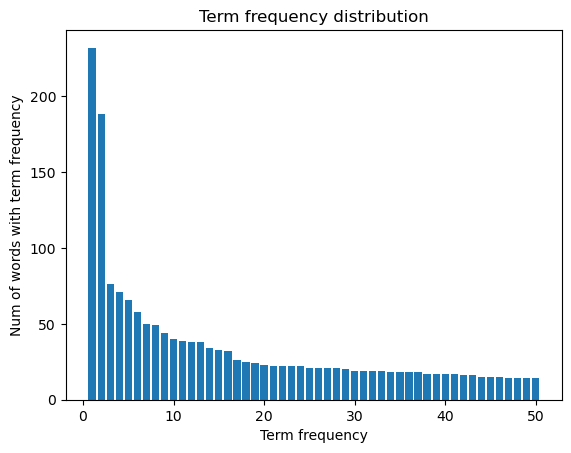

In [16]:
y = [count for tag, count in termFreqCounter.most_common(freqNum)]
x = range(1, len(y) + 1)

# use matplotlib bar chat to plot this
plt.bar(x, y)
plt.title("Term frequency distribution")
plt.ylabel('Num of words with term frequency')
plt.xlabel('Term frequency')
plt.show()

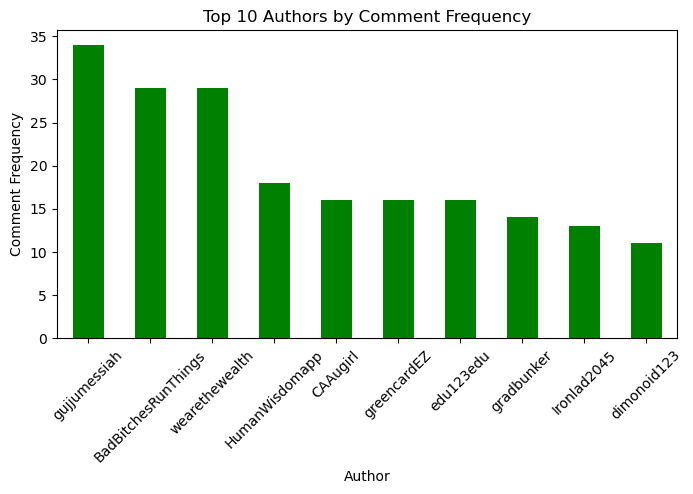

In [4]:

comment_data = []
with open("international_students.json", "r") as file:
    for line in file:
        json_data = json.loads(line)
        comments = json_data.get("comments", [])
       
        for comment in comments:
            comment_date_str = comment.get("created_utc", "")
            if comment_date_str:
                comment_date = datetime.strptime(comment_date_str, '%Y-%m-%d').date()
            else:
                comment_date = None

            comment_data.append({
                'author': comment.get("author", None),
                'created_utc': comment_date.strftime('%Y-%m-%d') if comment_date else None,
                'body': comment.get("body", None)
            })

df = pd.DataFrame(comment_data)

author_counts = df['author'].value_counts()

top_10_authors = author_counts.head(10)


plt.figure(figsize=(8,4))
top_10_authors.plot(kind='bar', color='green')
plt.title("Top 10 Authors by Comment Frequency")
plt.xlabel("Author")
plt.ylabel("Comment Frequency")
plt.xticks(rotation=45)
plt.show()